# Machine Learning con Applicazioni
##### Andrea Sala - 983944


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')

In [104]:
fileName = "wine_dataset.csv"
df = pd.read_csv(fileName)
df['style'] = df['style'].replace('red', 0)
df['style'] = df['style'].replace('white',1)
df['score'] = df['quality']
df['score'].astype(int)
del df['quality']
y = df['score']
print(df.shape)

(6497, 13)


<AxesSubplot:>

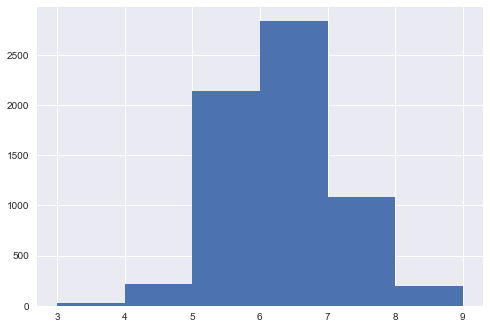

In [105]:
df['score'].hist(bins=6)

### Correlation Matrix

<AxesSubplot:>

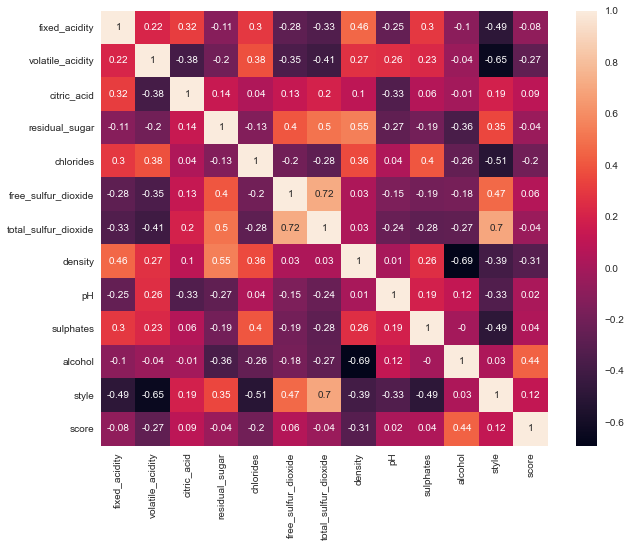

In [106]:
CorMat = df.corr().round(2)
fig = plt.figure(figsize=(10,8))
sns.heatmap(data=CorMat, annot=True)

In [107]:
## Removing all variables that have |correlation|<0.1 with SCORE
#corr_cols=['volatile_acidity', 'chlorides', 'density', 'alcohol', 'style', 'score']
#df = df[corr_cols]
#df.shape

#IT ACTUALLY WORSENS THE PREDICTOR

### PCA

In [108]:
# Centering the Matrix

feature_cols= ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
               'free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol', 'style']

dfC = df[feature_cols]
dfC = dfC - dfC.mean(axis=0)
#eseguo splitting
X_train, X_test, y_train, y_test = train_test_split(dfC[feature_cols], y,test_size=0.18)
y_train, y_test = y_train.astype(int), y_test.astype(int)
print(X_train.shape)

(5327, 12)


In [137]:
pca = PCA(n_components = .99)
X_pca = pca.fit_transform(X_train)
print(X_pca.shape)

(5327, 2)


In [110]:
pca.components_

array([[-7.23396415e-03, -1.20338538e-03,  5.05104390e-04,
         4.14806733e-02, -1.69453672e-04,  2.31286832e-01,
         9.71943267e-01,  2.07893462e-06, -6.77404549e-04,
        -6.96054256e-04, -5.49441913e-03,  5.18145356e-03]])

### Support Vector Machine

In [111]:
#X_train = X_pca

In [112]:
from sklearn import svm

In [113]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [114]:
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.5452991452991452
Accuracy Polynomial Kernel: 0.45726495726495725
Accuracy Radial Basis Kernel: 0.6324786324786325
Accuracy Sigmoid Kernel: 0.3504273504273504


In [115]:
# try different RBFs -- gamma

In [116]:
gammas = [0.1, 1.0, 2.5, 5, 7.5, 10]
for g in gammas:
    print("Accuracy with RBF kernel, C = 1, gamma=",g, ":", end=' ')
    print(svm.SVC(kernel='rbf', gamma=g, C=1, decision_function_shape='ovo').fit(X_train, y_train)
          .score(X_test,y_test))

Accuracy with RBF kernel, C = 1, gamma= 0.1 : 0.5854700854700855
Accuracy with RBF kernel, C = 1, gamma= 1.0 : 0.6324786324786325
Accuracy with RBF kernel, C = 1, gamma= 2.5 : 0.6307692307692307
Accuracy with RBF kernel, C = 1, gamma= 5 : 0.6316239316239316
Accuracy with RBF kernel, C = 1, gamma= 7.5 : 0.6324786324786325
Accuracy with RBF kernel, C = 1, gamma= 10 : 0.6324786324786325


In [117]:
#try different RBF-s -- C
gbest = 2.5

In [118]:
Cs = [0.1, 1.0, 10, 20]
for c in Cs:
    print("Accuracy with RBF kernel, C =",c, ",gamma = 2.5:", end=' ')
    print(svm.SVC(kernel='rbf', gamma=gbest, C=c, decision_function_shape='ovo').fit(X_train, y_train)
          .score(X_test,y_test))

Accuracy with RBF kernel, C = 0.1 ,gamma = 2.5: 0.452991452991453
Accuracy with RBF kernel, C = 1.0 ,gamma = 2.5: 0.6307692307692307
Accuracy with RBF kernel, C = 10 ,gamma = 2.5: 0.6316239316239316
Accuracy with RBF kernel, C = 20 ,gamma = 2.5: 0.6316239316239316


In [119]:
#final result

In [120]:
top_svm = svm.SVC(kernel='rbf', gamma=5, C=1, decision_function_shape='ovo').fit(X_train, y_train)
svm_score = top_svm.score(X_test,y_test)
print("Best accuracy achievable with SVM: ", svm_score)

Best accuracy achievable with SVM:  0.6316239316239316


### Random Forest

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [122]:
d_tree = DecisionTreeClassifier(criterion='gini')
d_tree.fit(X_train,y_train)
print("Max depth:",d_tree.tree_.max_depth)
print("Feature weights:")
print(d_tree.feature_importances_)
#The importance of a feature is computed as the (normalized)
# total reduction of the criterion brought by that feature.
# It is also known as the Gini importance.

Max depth: 25
Feature weights:
[0.08236749 0.09905754 0.07858516 0.08645561 0.08541128 0.09431945
 0.09178544 0.07622302 0.08502225 0.08643971 0.13229096 0.00204208]


In [123]:
Ntrees = [5,10,20,50,100,200,500,1000,5000]
Acc    = []
for n in Ntrees:
    RT = RandomForestClassifier(n_estimators=n)
    RT.fit(X_train,y_train)
    score = RT.score(X_test,y_test)
    Acc.append(score)
    print("Random Forest Accuracy with ", n, " trees: ", score)

Random Forest Accuracy with  5  trees:  0.6564102564102564
Random Forest Accuracy with  10  trees:  0.6760683760683761
Random Forest Accuracy with  20  trees:  0.688034188034188
Random Forest Accuracy with  50  trees:  0.6965811965811965
Random Forest Accuracy with  100  trees:  0.7042735042735043
Random Forest Accuracy with  200  trees:  0.7017094017094017
Random Forest Accuracy with  500  trees:  0.7076923076923077
Random Forest Accuracy with  1000  trees:  0.7068376068376069
Random Forest Accuracy with  5000  trees:  0.7068376068376069


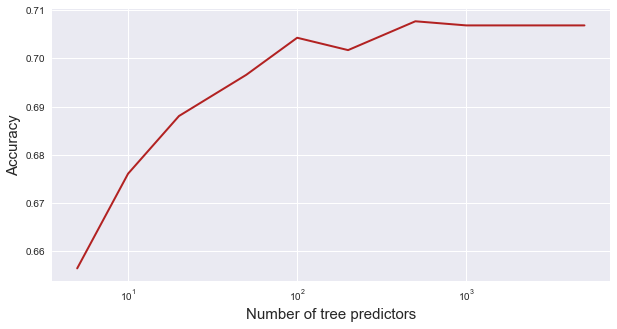

In [124]:
plt.figure(figsize=(10,5))
plt.plot(Ntrees, Acc, color='firebrick',linewidth=2)
plt.xlabel("Number of tree predictors", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xscale("log")
plt.show()

In [125]:
rf_g = RandomForestClassifier(n_estimators=1000, criterion='gini').fit(X_train,y_train)
svm_score_g = rf_g.score(X_test,y_test)
rf_e = RandomForestClassifier(n_estimators=1000, criterion='entropy').fit(X_train,y_train)
svm_score_e = rf_e.score(X_test,y_test)
print("Accuracy Random Forest - entropy: ", svm_score_e)
print("Accuracy Random Forest - gini: ", svm_score_g)

Accuracy Random Forest - entropy:  0.7145299145299145
Accuracy Random Forest - gini:  0.7068376068376069


In [126]:
print("Best accuracy achievable with Random Forest: ", svm_score_e)

Best accuracy achievable with Random Forest:  0.7145299145299145


In [139]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
rf_e_pca = RandomForestClassifier(n_estimators=1000, criterion='entropy').fit(X_train_pca,y_train)
svm_score_e_pca = rf_e_pca.score(X_test_pca,y_test)
print("Best accuracy achievable with Random Forest and PCA: {}".format(svm_score_e_pca))

Best accuracy achievable with Random Forest and PCA: 0.4307692307692308


### Neural Networks

In [ ]:
# go on colab